In [1]:
from typing import List
import numpy as np
from math import sqrt
from numpy import heaviside
from functools import partial
from scipy.integrate import solve_ivp

In [2]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl
# matplotlib widget #inline #notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import matplotlib as mpl

In [3]:
def vp(t, t0 = 1., t1 = 4.0) -> float:
    # v+ velocity input signal
    return heaviside(t - t0, 0.5) * heaviside(t1 - t, 0.5)

In [4]:
def vm(t, t0 = 6., t1 = 8.) -> float:
    # v- velocity input signal
    return heaviside(t - t0, 0.5) * heaviside(t1 - t, 0.5)

In [5]:
def w_p(t: float, y: List[float]) -> List[float]:
    """weight value ode"""
    w_0 = y[0]
    w_1 = y[1]

    # w_0 decreases exponentially and w_1 filled accordingly
    # The 2nd term is meant to excite dominant fires:
    w_0p = - w_0 * vp(t) + w_1 * vm(t) + 10.0 * (w_0 - w_1) * (1. - w_0) * (1. - w_1) * w_1 * w_0 #+ 0.1 * (w_0 - 0.1 * w_1)
    w_1p = w_0 * vp(t) - w_1 * vm(t) + 10.0 * (w_1 - w_0) * (1. - w_0) * (1. - w_1) * w_1 * w_0 # * (1. - w_1)

    return [w_0p, w_1p]

Solve for time = [0, 10], with initial values: w_0 = 1 , w_1 = 0 :

In [6]:
sol = solve_ivp(
    w_p,
    [0, 10],
    [1., 0.],
    dense_output=True,
)

/var/folders/rn/678z32fn7lxgnhjt7mbjbyc400066l/T/ipykernel_30601/4043703309.py:8: RuntimeWarning: overflow encountered in double_scalars
  w_0p = - w_0 * vp(t) + w_1 * vm(t) + 10.0 * (w_0 - w_1) * (1. - w_0) * (1. - w_1) * w_1 * w_0 #+ 0.1 * (w_0 - 0.1 * w_1)
/var/folders/rn/678z32fn7lxgnhjt7mbjbyc400066l/T/ipykernel_30601/4043703309.py:9: RuntimeWarning: overflow encountered in double_scalars
  w_1p = w_0 * vp(t) - w_1 * vm(t) + 10.0 * (w_1 - w_0) * (1. - w_0) * (1. - w_1) * w_1 * w_0 # * (1. - w_1)


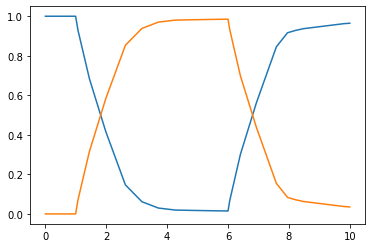

In [7]:
plt.plot(sol.t, sol.y.T)

In [8]:
vp(sol.t)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [9]:
def w2_p(t: float, y: List[float]) -> List[float]:
    """weight value ode"""
    '''
    w_0 = y[0]
    w_1 = y[1]

    # w_0 decreases exponentially and w_1 filled accordingly
    # The 2nd term is meant to excite dominant fires:
    w_0p = - w_0 * vp(t) + w_1 * vm(t) + 10.0 * (w_0 - w_1) * (1. - w_0) * (1. - w_1) * w_1 * w_0 #+ 0.1 * (w_0 - 0.1 * w_1)
    w_1p = w_0 * vp(t) - w_1 * vm(t) + 10.0 * (w_1 - w_0) * (1. - w_0) * (1. - w_1) * w_1 * w_0 # * (1. - w_1)

    w_damp = []
    for y_0, y_1 in zip(y, y[1:] + [y[0]]):
        w_damp.append( (y_0 - y_1) * (1. - y_0) * (1. - y_1) * y_0 * y_1 )
        
    w_damp_sum = np.array(w_damp).sum()
    '''
    
    w = np.array(y)

    wdiff = np.subtract.outer(w, w)
    fac = w * (1. - w)
    fac_mat = np.outer(fac, fac)
    
    # inhibition_mat_ij = (w_i - w_j) * w_i * (1 - w_i) * w_j * (1 - w_j):
    inhibition_mat = np.multiply( wdiff,  fac_mat)
    inhibition_term = inhibition_mat.sum(axis = 0)

    # proximal velocity stimulus:
    w0 = np.power(np.abs(np.array(y)), 1.)
    w_1 = np.roll(w0, 1)
    w1 = np.roll(w0, -1)

    vel_term = -(vp(t) + vm(t)) * w0 + vm(t) * w_1 + vp(t) * w1

    return 1. * vel_term - 20. * inhibition_term
    '''
    w_p = [0]*(len(y)+1)
    for i, (y_0, y_1) in enumerate(zip(y, y[1:] + [y[0]])): #, w_damp):        
        w_p[i] += - y_0 * vp(t) + y_1 * vm(t)
        w_p[i+1] += y_0 * vp(t) - y_1 * vm(t)

    return w_p[:-1]
    '''

In [10]:
w2_p(1.1, [0., 0., 1., 0., 0., 0., 0.])

array([ 0.,  1., -1.,  0.,  0.,  0.,  0.])

In [11]:
sol2 = solve_ivp(
    w2_p,
    [0, 10],
    [ 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    dense_output=True,
)

/Users/salmonson1/anaconda3/lib/python3.8/site-packages/numpy/core/numeric.py:942: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/var/folders/rn/678z32fn7lxgnhjt7mbjbyc400066l/T/ipykernel_30601/999682474.py:26: RuntimeWarning: overflow encountered in multiply
  inhibition_mat = np.multiply( wdiff,  fac_mat)
/var/folders/rn/678z32fn7lxgnhjt7mbjbyc400066l/T/ipykernel_30601/999682474.py:26: RuntimeWarning: invalid value encountered in multiply
  inhibition_mat = np.multiply( wdiff,  fac_mat)
/Users/salmonson1/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


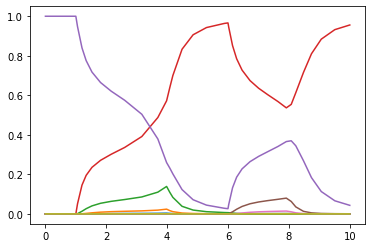

In [12]:
plt.plot(sol2.t, sol2.y.T)

In [13]:
sol2.y.T.shape

(47, 9)

In [14]:
sol2.y[:,20]

array([3.23831652e-03, 1.91546910e-02, 1.10080829e-01, 4.87676742e-01,
       3.79189336e-01, 2.83062564e-06, 1.60314801e-05, 9.42482403e-05,
       5.46974449e-04])

In [15]:
np.linspace(0., 360., sol2.y.T.shape[-1], endpoint=False)

array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320.])

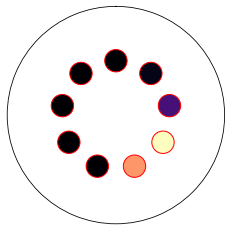

In [21]:
theta = np.linspace(0., 360., sol2.y.T.shape[-1], endpoint=False)
r = np.ones_like(theta)

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
ax.set_theta_zero_location("N") # theta = 0 is up
ax.set_theta_direction(-1) # clockwise
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
c = ax.scatter(np.radians(theta), r, c = sol2.y[:,20], edgecolors = "r", s = 500, cmap="magma") #mpl.colormaps["magma"]) #, c=colors, s=area, cmap='hsv', alpha=0.75) #s=area)